In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
import statsmodels.api as sm
from CTL.causal_tree_learn import CausalTree
from fancyimpute import IterativeImputer as MICE
import graphviz
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy
import econml
from econml.metalearners import SLearner, TLearner, XLearner
from econml.inference import BootstrapInference
from bartpy.sklearnmodel import SklearnModel # package maybe problematic
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import pickle

import warnings
warnings.filterwarnings("ignore")

/Users/fionaguo/.pyenv/versions/3.7.8/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Using TensorFlow backend.


# Preprocessing
drop linearly dependent features

drop columns with same values

drop columns with too many NaNs


Features should be used:
1. Demographics: Age, Sex, GPA, Years of Education
2. Surveys: Agreeableness, Beck Depression, Facets of Mindfulness, Karolinska Sleep, Loneliness, MAAS, Mood & Anxiety, Need for Cognition, NEO, Pittsburgh Sleep, Theories of Intelligence
3. Cognitive: Decision Making, Digit Symbol Substitution, Figure Series, Letter Completion, LSAT, Pattern Completion, Analogical Reasoning, Set Shifting, Shipley Vocabulary
4. Fitness: Accelerometry, BMI, Exertion, Body composition, Flexibility, Heart Rate, Height, Leg Length, VO2 Max, Waist, Weight
5. Nutrients: Alcohol, Alpha Tocopherol, Carbohydrates, Fats, Fiber, Folate – Grains, Linoleic Acid – MUFAs, Protein, PUFAs, SFAs, Sugar, Trans Fats – Vitamin A

Outcomes need to be predicted:
1. Fitness: Body Composition, Wait-Hip Ratio, Flexibility, VO2 Max
2. Cognition: Executive Function, Logical Reasoning, Pattern Recognition, Processing Efficiency, Decision Making: Sunken Cost, Decision Making: Social Norms, Decision Making: Over/Under Confidence

In [2]:
"""
This data is partially processed in R already 
    - combined 3 datasets: Questionnaire, NP, FitnessIntervention/pretest fitness 
    - only taking eligible and complete subjects
    - dropped redundant variables
    - dropped post variables in questionnaire dataset
"""
df_raw = pd.read_csv("sharp_np_q_fitness_R_processed.csv")
df_raw.rename(columns={"Group_np": "Group", "GoodVO2_np": "GoodVO2", "Unnamed: 0":"SubjectID"},inplace=True)
df_raw.set_index("SubjectID",inplace=True)
Group = df_raw["Group"].copy()
GoodVO2 = df_raw["GoodVO2"].copy()
df_raw.drop(["Group","GoodVO2"],axis=1,inplace=True)
# df.dtypes[df.dtypes != "float"]

In [3]:
# delete linearly dependent columns, columns with low variance and columns with too many NaNs
def remove_highly_correlated_cols(df, threshold=0.9, protected_columns=None):
    df_corr = df.corr().abs()
    to_drop = []
    for i, (c1, row) in enumerate(df_corr.iterrows()):
        if c1 not in to_drop:
            for j in range(i + 1, len(df_corr)):
                c2 = row.index[j]
                assert c2 != c1
                corr = row.iloc[j]
                if corr > threshold: # delete either c1 or c2
                    if c1 in protected_columns and c2 in protected_columns:
                        pass
                    elif c2 in protected_columns: # delete c1
                        if (c1 not in to_drop) and (not bool(re.search(r'^Post',c1))):
                            print("pair: ",c1,c2,"drop:",c1)
                            to_drop.append(c1)
                            break
                    else: # delete c2
                        if (c2 not in to_drop) and (not bool(re.search(r'^Post',c2))): # don't delete post variables for now
                            print("pair: ",c1,c2,"drop:",c2)
                            to_drop.append(c2)
    df = df.drop(columns=to_drop)
    print("%d pairs of columns have correlation > %.1f. "
       "Number of remaining columns %d"
       % (len(to_drop), threshold, len(df.columns)))
    # print("variable dropped: ",to_drop)
    return df

def drop_cols_low_var(df, threshold=0., protected_columns=None): # doesn't seem to allow NaNs
    if protected_columns is not None:
        columns = [c for c in df.columns if c not in protected_columns]
        df_ = df[columns]
    else:
        df_ = df
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(df_.values)
    to_drop = df_.columns[np.where(selector.get_support() == False)[0]]
    df = df.drop(columns=to_drop)
    print("%d columns have have variance <= %.1f. Number of remaining columns %d" 
       % (len(to_drop), threshold, len(df.columns)))
    return df

def drop_cols_same_value(df,protected_columns=None):
    if protected_columns is not None:
        columns = [c for c in df.columns if c not in protected_columns]
        df_ = df[columns]
    else:
        df_ = df
    # exam column by column
    to_drop = []
    for col_name,col in df_.items():
        if len(col.dropna().unique()) <= 1:
            to_drop.append(col_name)
    df = df.drop(columns=to_drop)
    print("%d columns dropped "
       "Number of remaining columns %d"
       % (len(to_drop), len(df.columns)))
    print("dropped columns: ",to_drop)
    return df

def drop_nan_cols(df, nan_thres=30, protected_columns=None, 
         plot_nan_count=False):
    if protected_columns is not None:
        columns = [c for c in df.columns if c not in protected_columns]
        df_ = df[columns]
    else:
        df_ = df
    # number of nans in columns 
    col_nan_ct = df_.isna().sum()
    if plot_nan_count:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
        sns.distplot(col_nan_ct, kde=False, ax=ax1)
        ax1.set_title("NaN count before removing")
    # remove columns with more than nan_thresh nan
    to_drop = [c for c in col_nan_ct.index if col_nan_ct.loc[c] > nan_thres]
    df = df.drop(columns=to_drop)
    if plot_nan_count:
        col_nan_ct = df.isna().sum()
        sns.distplot(col_nan_ct, kde=False, bins=10, ax=ax2)
        ax2.set_title("NaN count after removing")
        plt.show()
    print("%d columns have have nan count > %d. Number of remaining columns %d" 
       % (len(to_drop), nan_thres, len(df.columns)))
    return df

2 columns have have nan count > 60. Number of remaining columns 437


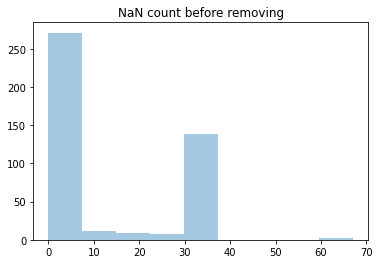

In [4]:
# look at NaNs in the data
col_nan_ct = df_raw.isna().sum()
sns.distplot(col_nan_ct, kde=False)
plt.title("NaN count before removing")
col_nan_ct[col_nan_ct > 30]
# almost all the nutrient features are missing data from the same 31 people
# dont want to delete all nutrient feaures
# imputation instead
# delete sleepquality and duration

df_preprocess = drop_nan_cols(df_raw, nan_thres=60, protected_columns=None)

In [5]:
# drop low variance columns
df_preprocess = drop_cols_same_value(df_preprocess)

# drop linearly dependent columns
df_preprocess = remove_highly_correlated_cols(df_preprocess,protected_columns=["PreTokenTaskFalseAlarms","PreiPositionArrangement","PreiPositionDistance","PreDSSTCorrect","PreLetterCompCorrectTrials","PrePatternCompCorrectTrials","PreADMCMeanZScore","VO2max_rel","WH_Ratio","TOTAL_FAT_MASS","TOTAL_LEAN_MASS","Flex"])

# finish preprocessing
print("df shape:",df_preprocess.shape)
df_preprocess

0 columns dropped Number of remaining columns 437
dropped columns:  []
pair:  PreTokenTaskTargOverlap1RT PreTokenTaskTargOverlap2RT drop: PreTokenTaskTargOverlap2RT
pair:  PreLetterCompAttemptedTrials PreLetterCompCorrectTrials drop: PreLetterCompAttemptedTrials
pair:  PreLetterCompCorrectTrials PreLetterCompAvgRT drop: PreLetterCompAvgRT
pair:  PreLetterCompCorrectTrials PreLetterCompCorrectRT drop: PreLetterCompCorrectRT
pair:  PrePatternCompAttemptedTrials PrePatternCompCorrectTrials drop: PrePatternCompAttemptedTrials
pair:  PrePatternCompAvgRT PrePatternCompCorrectRT drop: PrePatternCompCorrectRT
pair:  PreADMCDate PreADMCDateScaled drop: PreADMCDateScaled
pair:  PreDSSTCorrect PreDSSTAttempted drop: PreDSSTAttempted
pair:  PreiPositionSwapsAvg PreiPositionMisplacementsAvg drop: PreiPositionMisplacementsAvg
pair:  PreiPositionSwapsAvg PreiPositionEdgeResizingAvg drop: PreiPositionEdgeResizingAvg
pair:  PreiPositionSwapsAvg PreiPositionEdgeDeflectionAvg drop: PreiPositionEdgeDeflec

,PreTokenTaskTargOverlap1Acc,PreTokenTaskTargOverlap1RT,PreTokenTaskTargOverlap2Acc,PreTokenTaskTargOverlap3Pos6Acc,PreTokenTaskTargOverlap3Pos6RT,PreTokenTaskTargOverlap3Pos8Acc,PreTokenTaskTargOverlap3Pos8RT,PreTokenTaskTargOverlap3Pos10Acc,PreTokenTaskTargOverlap3Pos10RT,PreTokenTaskDprime,...,Inositol..g.,Mannitol..g.,Pinitol..g.,Sorbitol..g.,Xylitol..g.,Total.Conjugated.Linoleic.Acid..CLA.18.2...g.,Tagatose..mg.,Vitamin.D2..ergocalciferol...mcg.,Whole.Grains..ounce.equivalents.,Refined.Grains..ounce.equivalents.
SubjectID,,,,,,,,,,,,,,,,,,,,,
4003,1.000000,1006.662698,0.984127,0.916667,1719.583333,0.833333,1591.166667,0.916667,1409.916667,-0.19571,...,0.044667,0.280333,0.006667,0.015667,0.013333,0.036667,0.218000,0.026000,2.284333,7.898333
4005,1.000000,478.087302,0.976190,0.916667,1029.416667,0.833333,952.083333,0.750000,908.833333,-0.60113,...,0.046333,0.482000,0.012333,0.042667,0.010000,0.407333,0.271667,0.000000,0.971000,5.220333
4008,0.996032,894.634921,0.976190,0.666667,1870.416667,0.916667,1554.000000,0.916667,1794.916667,-0.90691,...,0.109333,0.031667,0.003000,0.034333,0.006667,0.111333,0.018667,0.000000,2.637333,5.030333
4011,1.000000,875.642857,0.968254,0.916667,1875.500000,1.000000,1659.916667,0.750000,1655.250000,-0.76621,...,0.027333,0.123667,0.000667,0.395000,0.007667,0.108000,2.031667,0.004000,1.305333,5.054667
4012,1.000000,829.888889,0.992063,0.833333,1495.500000,1.000000,1646.833333,1.000000,1716.833333,0.27318,...,0.169333,0.394000,0.078000,0.028333,0.011333,0.106667,1.881000,0.000000,0.068333,3.097333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4600,1.000000,576.317460,0.984127,1.000000,1584.250000,1.000000,1330.250000,0.916667,1420.750000,0.59246,...,0.060000,0.059333,0.030333,0.512667,0.036667,0.062333,1.166000,0.003333,0.336333,3.631333
4605,1.000000,722.257937,0.992063,1.000000,2334.166667,0.916667,2043.500000,0.833333,2428.083333,0.36584,...,0.020000,0.220000,0.000000,0.012333,0.009000,0.094667,1.661333,0.003667,1.608000,2.859000
4606,1.000000,944.837302,0.968254,0.833333,1535.166667,0.666667,1233.916667,0.666667,1295.333333,-1.31542,...,0.006000,0.058667,0.000000,0.020000,0.001667,0.300667,0.361000,0.000000,0.000000,7.196333


# Data Imputation

In [6]:
# imputation using MICE - average already taken from 5 imputed datasets (???)
mice_imputer = MICE()
df = df_preprocess.copy(deep=True)
df = mice_imputer.fit_transform(df)

In [7]:
# first import post fitness test data
df_post_fitness = pd.read_csv("FitnessIntervention/INSIGHT1b Post Test Fitness Testing Database.csv")
df_post_fitness = df_post_fitness[-df_post_fitness["SubjectID"].isnull()]
df_post_fitness["SubjectID"] = df_post_fitness["SubjectID"].astype(int)
df_post_fitness.set_index("SubjectID",inplace=True)
df_post_fitness = df_post_fitness.loc[df_raw.index,]

mice_imputer = MICE()
# take needed columns only
df_post_fitness = mice_imputer.fit_transform(df_post_fitness[["VO2max_rel","WH_Ratio","TOTAL_FAT_MASS","TOTAL_LEAN_MASS","Flex"]])

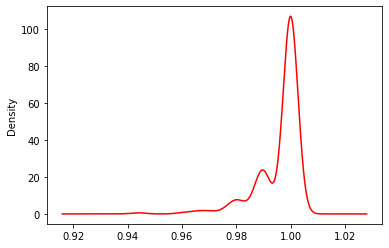

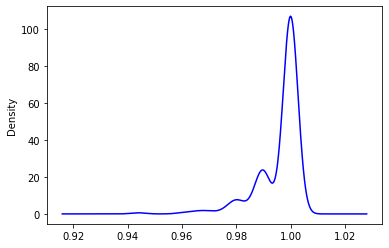

,PreTokenTaskTargOverlap1Acc,PreTokenTaskTargOverlap1RT,PreTokenTaskTargOverlap2Acc,PreTokenTaskTargOverlap3Pos6Acc,PreTokenTaskTargOverlap3Pos6RT,PreTokenTaskTargOverlap3Pos8Acc,PreTokenTaskTargOverlap3Pos8RT,PreTokenTaskTargOverlap3Pos10Acc,PreTokenTaskTargOverlap3Pos10RT,PreTokenTaskDprime,...,Inositol..g.,Mannitol..g.,Pinitol..g.,Sorbitol..g.,Xylitol..g.,Total.Conjugated.Linoleic.Acid..CLA.18.2...g.,Tagatose..mg.,Vitamin.D2..ergocalciferol...mcg.,Whole.Grains..ounce.equivalents.,Refined.Grains..ounce.equivalents.
SubjectID,,,,,,,,,,,,,,,,,,,,,
4003,1.000000,1006.662698,0.984127,0.916667,1719.583333,0.833333,1591.166667,0.916667,1409.916667,-0.19571,...,0.044667,0.280333,0.006667,0.015667,0.013333,0.036667,0.218000,0.026000,2.284333,7.898333
4005,1.000000,478.087302,0.976190,0.916667,1029.416667,0.833333,952.083333,0.750000,908.833333,-0.60113,...,0.046333,0.482000,0.012333,0.042667,0.010000,0.407333,0.271667,0.000000,0.971000,5.220333
4008,0.996032,894.634921,0.976190,0.666667,1870.416667,0.916667,1554.000000,0.916667,1794.916667,-0.90691,...,0.109333,0.031667,0.003000,0.034333,0.006667,0.111333,0.018667,0.000000,2.637333,5.030333
4011,1.000000,875.642857,0.968254,0.916667,1875.500000,1.000000,1659.916667,0.750000,1655.250000,-0.76621,...,0.027333,0.123667,0.000667,0.395000,0.007667,0.108000,2.031667,0.004000,1.305333,5.054667
4012,1.000000,829.888889,0.992063,0.833333,1495.500000,1.000000,1646.833333,1.000000,1716.833333,0.27318,...,0.169333,0.394000,0.078000,0.028333,0.011333,0.106667,1.881000,0.000000,0.068333,3.097333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4600,1.000000,576.317460,0.984127,1.000000,1584.250000,1.000000,1330.250000,0.916667,1420.750000,0.59246,...,0.060000,0.059333,0.030333,0.512667,0.036667,0.062333,1.166000,0.003333,0.336333,3.631333
4605,1.000000,722.257937,0.992063,1.000000,2334.166667,0.916667,2043.500000,0.833333,2428.083333,0.36584,...,0.020000,0.220000,0.000000,0.012333,0.009000,0.094667,1.661333,0.003667,1.608000,2.859000
4606,1.000000,944.837302,0.968254,0.833333,1535.166667,0.666667,1233.916667,0.666667,1295.333333,-1.31542,...,0.006000,0.058667,0.000000,0.020000,0.001667,0.300667,0.361000,0.000000,0.000000,7.196333


In [8]:
# output from MICE is np arrray, convert back to pd df
df = pd.DataFrame(df,index=df_preprocess.index,columns=df_preprocess.columns)
df_post_fitness = pd.DataFrame(df_post_fitness,index=df_raw.index,columns=["VO2max_rel","WH_Ratio","TOTAL_FAT_MASS","TOTAL_LEAN_MASS","Flex"])

# check distribution before and after imputation
df["PostDSSTAccuracy"].plot(kind="kde",c="red")
plt.show()
df_raw["PostDSSTAccuracy"].plot(kind="kde",c="blue")
plt.show()
df

In [9]:
# output imputed data
df.to_csv("sharp_np_q_fitness_imputed.csv")

# df = pd.read_csv("sharp_np_q_fitness_imputed.csv")

# Outcomes

In [10]:
def normalize(column):
    return (column - column.mean())/column.std()

In [11]:
# defining outcome variables (post - pre) again after imputation: cognition
changeRelationalMemory = (df["PostTokenTaskFalseAlarms"] - df["PreTokenTaskFalseAlarms"]) + (df["PostiPositionArrangement"] - df["PreiPositionArrangement"]) + (df["PostiPositionDistance"] - df["PreiPositionDistance"])
changeProcessingSpeed = (df["PostDSSTCorrect"] - df["PreDSSTCorrect"]) + (df["PostLetterCompCorrectTrials"] - df["PreLetterCompCorrectTrials"]) + (df["PostPatternCompCorrectTrials"] - df["PrePatternCompCorrectTrials"])
changeDecisionMaking = df["PostADMCMeanZScore"] - df["PreADMCMeanZScore"]
changeDSSTCorrect = df["PostDSSTCorrect"] - df["PreDSSTCorrect"]

# define outcome variables (post - pre): fitness
changeVO2 = df_post_fitness["VO2max_rel"] - df["VO2max_rel"]
changeWHRatio = df_post_fitness["WH_Ratio"] - df["WH_Ratio"]
post_fat_perc = df_post_fitness["TOTAL_FAT_MASS"] / (df_post_fitness["TOTAL_FAT_MASS"] + df_post_fitness["TOTAL_LEAN_MASS"])
pre_fat_perc = df["TOTAL_FAT_MASS"] / (df["TOTAL_FAT_MASS"] + df["TOTAL_LEAN_MASS"])
changeFatPerc = post_fat_perc - pre_fat_perc
changeFlexibility = df_post_fitness["Flex"] - df["Flex"]

outcome_vars = {"changeRelationalMemory":changeRelationalMemory,"changeProcessingSpeed":changeProcessingSpeed,"changeDecisionMaking":changeDecisionMaking,"changeDSSTCorrect":changeDSSTCorrect,"changeVO2":changeVO2,"changeWHRatio":changeWHRatio,"changeFatPerc":changeFatPerc,"changeFlexibility":changeFlexibility}


for k,v in outcome_vars.items():
    outcome_vars[k] = normalize(v)

In [12]:
# save outcomes
with open("sharp_outcomes.pickle","wb") as handle:
    pickle.dump(outcome_vars,handle,protocol=pickle.HIGHEST_PROTOCOL)

# Treatment

In [13]:
# Define treatment
treatment_2to1 = Group[(Group == 1) | (Group == 2)].copy()
treatment_2to1[treatment_2to1 == 1] = 0
treatment_2to1[treatment_2to1 == 2] = 1

treatment_3to1 = Group[(Group == 1) | (Group == 3)].copy()
treatment_3to1[treatment_3to1 == 1] = 0
treatment_3to1[treatment_3to1 == 3] = 1

treatment_4to1 = Group[(Group == 1) | (Group == 4)].copy()
treatment_4to1[treatment_4to1 == 1] = 0
treatment_4to1[treatment_4to1 == 4] = 1

treatment_3to2 = Group[(Group == 3) | (Group == 2)].copy()
treatment_3to2[treatment_3to2 == 2] = 0
treatment_3to2[treatment_3to2 == 3] = 1

treatment_4to3 = Group[(Group == 3) | (Group == 4)].copy()
treatment_4to3[treatment_4to3 == 3] = 0
treatment_4to3[treatment_4to3 == 4] = 1

treatment = {"G2-G1":treatment_2to1,"G3-G1":treatment_3to1,"G4-G1":treatment_4to1,"G3-G2":treatment_3to2,"G4-G3":treatment_4to3}

In [14]:
# save
with open("sharp_treatment.pickle","wb") as handle:
    pickle.dump(treatment,handle,protocol=pickle.HIGHEST_PROTOCOL)

# Feature matrix

In [15]:
# delete post variables in df
print(df.shape)
post_var = df.columns[[bool(re.search(r'^Post', x)) for x in df.columns.values]]
df.drop(columns=post_var,inplace=True)
print(df.shape)

(243, 281)
(243, 238)


In [20]:
# drop most of nutrient features as they impose too much noise to the results
# save first and remove nutrients in excel directly
# df.to_csv("sharp_np_q_fitness_imputed_w_nutrients.csv") # => saved as: sharp_np_q_fitness_preprocessed.csv

# most of nutrients are removed, most of the flexibility variables are removed, most of the body part fat perc are removed
df = pd.read_csv("sharp_np_q_fitness_preprocessed.csv") 
df.set_index("SubjectID",inplace=True)

# PCA

In [21]:
# perform PCA on pre-treatment features - df
X = StandardScaler().fit_transform(df)
# X = df - df.mean()
pca = PCA()
x_pca = pca.fit_transform(X)
print("percent variance explained in first 2 PCs = ",sum(pca.explained_variance_ratio_[:35]))
pca_colNames = ["PC_"+str(i) for i in range(1,36)]
X_pca = pd.DataFrame(x_pca[:,:35],index = df.index,columns=pca_colNames)
X_pca

percent variance explained in first 2 PCs =  0.8179293541073968


,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_26,PC_27,PC_28,PC_29,PC_30,PC_31,PC_32,PC_33,PC_34,PC_35
SubjectID,,,,,,,,,,,,,,,,,,,,,
4003,1.456248,0.607618,-5.232235,0.742335,0.312332,-2.807668,-0.296117,-1.108600,0.424127,0.802711,...,-0.496739,-0.632310,-0.077597,-0.601889,-0.727837,0.287000,-0.368189,-1.645473,0.052102,-1.689829
4005,4.138334,-4.147807,5.070592,-0.955623,3.156250,-0.778245,-0.342838,0.713577,0.341533,-0.942673,...,-0.667876,0.871978,0.644762,-0.008917,0.415338,-0.600097,0.594273,-2.375160,-0.057274,0.419993
4008,4.660650,2.880820,-0.053559,-2.165354,1.089870,-0.852589,2.863372,1.415162,0.080608,0.600033,...,1.183049,-1.076249,0.538005,-0.405498,-0.472750,-1.225420,-0.523413,-0.420679,-0.314901,0.075308
4011,0.447531,0.149102,-1.218830,0.558892,1.680089,1.092499,-1.371237,0.022653,2.292978,-0.916697,...,-1.279626,1.248224,1.325661,-1.349950,0.488645,-0.472819,0.948009,-0.384950,-0.139801,0.892613
4012,-3.563459,1.517922,2.066753,-0.324752,-0.513831,2.388662,0.083301,-0.593457,-0.515493,-1.175633,...,1.168992,-0.586694,0.354394,1.904541,1.291086,-0.461333,-0.969245,0.314825,-0.054388,-0.355241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4600,-0.249586,-3.018538,-2.602151,-0.508565,0.475986,1.000977,-1.394374,-1.655893,0.003108,-0.537885,...,-0.187247,0.190340,-0.283462,-1.159441,0.791642,0.722378,-0.051049,0.769881,-0.243610,-0.594294
4605,-2.777309,4.896538,0.178248,-1.707999,-2.916576,2.063755,1.118276,-0.411467,0.598627,2.428149,...,-1.291791,1.892770,1.276210,0.070616,-0.771406,-0.788722,-0.610135,0.523970,-0.544337,1.022637
4606,-0.199977,-0.984518,-0.698717,-0.380586,2.541595,1.921778,-0.204263,3.677080,-0.902650,1.100285,...,-0.963495,0.786256,-0.724320,0.499096,-1.835581,-0.785615,-0.083116,-1.594505,1.023084,-0.717383


In [22]:
# save pca
X_pca.to_csv("sharp_np_q_fitniss_pca.csv")

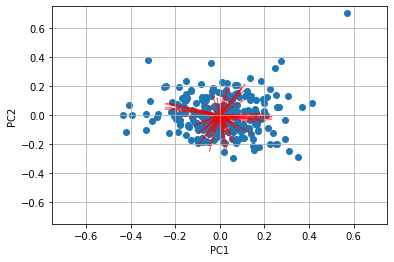

In [23]:
# bi-plot for PCA
def biplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
#         if labels is None:
#             plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
#         else:
#             plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-0.75,0.75)
    plt.ylim(-0.75,0.75)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

#Call the function. Use only the 2 PCs.
biplot(x_pca[:,0:2],np.transpose(pca.components_[:2,:]))
plt.show()